In [13]:
"""
This Jupyter notebook provides examples for loading data and running baselines from the Treated Room.
"""
import sys
sys.path.insert(0, '../dataset/')
import dataset
import room_setup
import room_config
import dataset
import os
import numpy as np
import s3fs
import zipfile

In [16]:
DATASET_BASE_PATH = "/home/onyxia/work/ia_data_hack_acoustic/data/LivingRoom_preprocessed_hack/" #<---Use the path in your directory

DATASET_PATH = os.path.join(DATASET_BASE_PATH, "Human1") 

dr = dataset.Dataset(room_setup.RoomSetup(room_config.speaker_xyz,
                room_config.mic_xyzs_base,
                room_config.x_min,
                room_config.x_max,
                room_config.y_min,
                room_config.y_max,
                room_config.walls), DATASET_PATH)


print("Treated Room Dataset Loaded")

Treated Room Dataset Loaded


In [17]:
#Loading centroid (human xy positions)
centroid = np.load(os.path.join(DATASET_PATH, "centroid.npy"))
print("Shape of Centroid:")
print(centroid.shape)


#Loading Room Impulse Response (1000 human locations x 10 microphones x M time samples)
RIRs = np.load(os.path.join(DATASET_PATH, "deconvoled_trim.npy"), mmap_mode='r')
print("Shape of RIRs:")
print(RIRs.shape)

Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)


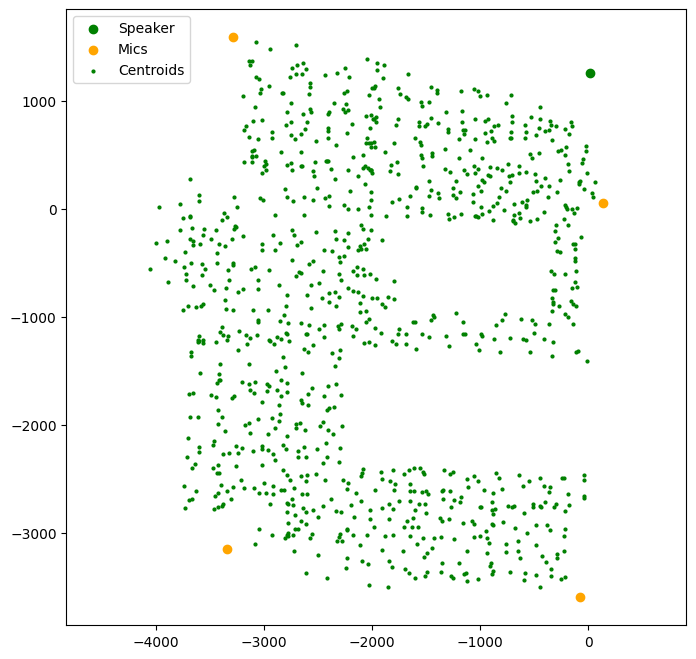

In [18]:
dr.room_setup.plot_room(centroid)

In [19]:
train_indices = np.load("../indices/train_indices.npy")
train_xys = centroid[train_indices]

print("Shape of Training xys")
print(train_xys.shape)

Shape of Training xys
(800, 2)


In [20]:
rir_path = os.path.join(DATASET_PATH, "deconvoled_trim.npy")
centroid_path = os.path.join(DATASET_PATH, "centroid.npy")

In [21]:
import os
import random
import sys
import numpy as np
import torch
import torchaudio.functional as F

sys.path.insert(0, '../VGGish/')
import config
import models

In [22]:
#déclaration de variables
normalized=False
multi_chan=False
complex_vggish=False
resnet1d=False
wavelet=False
pretrained=False
seed=1337
batch_size = 256
epochs = 2

In [23]:
rand = random.Random(seed)
    
np.random.seed(0)
deconv = RIRs
print("Deconv Loaded")
print("Centroid Loaded")

mic_indices = [0]


Deconv Loaded
Centroid Loaded


In [24]:
deconv = deconv[:, mic_indices, :]
print(deconv.shape)
print(centroid.shape)

(1000, 1, 667200)
(1000, 2)


In [25]:
train_indices = np.load("../indices/train_indices.npy")
valid_indices = np.load("../indices/valid_indices.npy")
test_indices = np.load("../indices/test_indices.npy")

In [26]:
#Centroids
train_xy = centroid[train_indices]
valid_xy = centroid[valid_indices]
test_xy = centroid[test_indices]

train_mean = np.mean(train_xy, axis=0)
train_std = np.std(train_xy, axis=0)

print(train_std)
print(np.max(train_xy, axis=0))
print(np.min(train_xy, axis=0))
train_xy = (train_xy - train_mean) / (train_std + 1e-8)
valid_xy = (valid_xy - train_mean) / (train_std + 1e-8)
test_xy =  (test_xy - train_mean) / (train_std + 1e-8)

[1065.49002101 1413.40889991]
[  56.83489407 1542.25968982]
[-4002.15528594 -3499.88767611]


In [28]:
#Code insertion ends
epsilon = 1e-2
norm_val_min = np.min(np.concatenate((train_xy, valid_xy), axis=0))
norm_val_range = np.max(np.concatenate((train_xy, valid_xy), axis=0)) - norm_val_min

In [29]:
def postprocess_net_output(output):
    output[:, :2] = norm_val_range * ((torch.tanh(output[:, :2]) * (1 + epsilon)) + 1) / 2 + norm_val_min
    return output


train_std_cuda = torch.Tensor(train_std).cuda()
train_mean_cuda = torch.Tensor(train_mean).cuda()

In [30]:
def unnormalize(xy):
    return xy*(train_std_cuda + 1e-8) + train_mean_cuda

def resample(audio, ir=48000, tr=16000):

    resampled_waveform = F.resample(
    audio,
    ir,
    tr,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
    )
    return resampled_waveform

In [33]:
train_waves = deconv[train_indices, :]
# 30950 seems to be the rough cutoff after which vggish treats the input as two examples.
valid_waves = deconv[valid_indices, :]
#Test Waves
test_waves = deconv[test_indices, :]

offset = 0
precutoff = 92850

In [34]:
train_waves = train_waves[..., (offset):(offset+precutoff)]
valid_waves = valid_waves[..., (offset):(offset+precutoff)]
test_waves = test_waves[..., (offset):(offset+precutoff)]

train_waves = torch.Tensor(train_waves).cuda()
train_xy = torch.Tensor(train_xy).cuda()

valid_waves = torch.Tensor(valid_waves).cuda()
valid_xy = torch.Tensor(valid_xy).cuda()

test_waves = torch.Tensor(test_waves).cuda()
test_xy = torch.Tensor(test_xy).cuda()

In [36]:
vggish_cutoff = 30950

train_waves = train_waves[..., :vggish_cutoff]
valid_waves = valid_waves[..., :vggish_cutoff]
test_waves = test_waves[..., :vggish_cutoff]

out_channels = 2

print("Done Resampling")

Done Resampling


In [39]:
train_waves = torch.mean(train_waves, dim=1)
valid_waves = torch.mean(valid_waves, dim=1)
test_waves = torch.mean(test_waves, dim=1)

net = models.get_finetune_model(pretrained, pretrained, out_channels)
print('Using VGGish-based model')

Using VGGish-based model


In [40]:
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('Total parameters: %i'%total_params)
print('Trainable parameters: %i'%trainable_params)

Total parameters: 72240514
Trainable parameters: 72240514


In [43]:
xy_loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=net.parameters(), betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999995)

print("Number of samples per epoch:", train_waves.shape[0])

Number of samples per epoch: 800


In [46]:
N_iter = int(train_waves.shape[0] / batch_size)
train_losses = []
train_xy_losses = []
valid_losses = []
valid_xy_losses = []
step_count = 0
for n in range(epochs):
    print('Reshuffling for Epoch %i'%n, flush=True)
    rand_idx = np.random.permutation(train_waves.shape[0])
    net.train()
    optimizer.zero_grad()
    for i in range(N_iter):
        curr_idx = rand_idx[i*batch_size:(i+1)*batch_size]
        net_out = net(train_waves[curr_idx, :])
        results = postprocess_net_output(net_out)
        xy_loss = xy_loss_fn(results[:, :2], train_xy[curr_idx, :2])
        loss = xy_loss
        optimizer.zero_grad()
        loss.backward()
        train_loss = loss.item()
        train_losses.append((step_count, train_loss))
        train_xy_losses.append((step_count, xy_loss.item()))
        step_count+=1
        optimizer.step()
        scheduler.step()

    net.eval()
    valid_loss_xy_arr = np.zeros(valid_waves.shape[0], dtype=np.float32)
    valid_loss_arr = np.zeros(valid_waves.shape[0], dtype=np.float32)
    for i in range(valid_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(net(torch.unsqueeze(valid_waves[i, :], axis=0)).view(-1, 1)))
        xy_loss = xy_loss_fn(results[:2], valid_xy[i, :2])
        valid_loss_xy_arr[i] = xy_loss.item()
        loss = xy_loss
        valid_loss_arr[i] = loss.item()
    valid_xy_loss = np.mean(valid_loss_xy_arr)
    valid_loss = np.mean(valid_loss_arr)
    print('Validation XY Loss: %0.3f'%valid_xy_loss)
    print('Validation Loss: %0.3f'%valid_loss)
    valid_losses.append((step_count, valid_loss))
    valid_xy_losses.append((step_count, valid_xy_loss))

    error_path = '../err'

    if not os.path.exists(error_path):
        os.makedirs(error_path)

    np.save(os.path.join(error_path, 'train_losses.npy'), np.array(train_losses, dtype=np.float32))
    np.save(os.path.join(error_path, 'valid_losses.npy'), np.array(valid_losses, dtype=np.float32))

    #Iterate through test
    test_errors = np.zeros(test_waves.shape[0], dtype=np.float32)

    for i in range(test_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(net(torch.unsqueeze(test_waves[i, :], axis=0)).view(-1, 1)))
        
        
        test_errors[i] = torch.norm(unnormalize(results[:2]) - unnormalize(test_xy[i, :2])).item()

    print("TEST ERROR")
    print(test_errors)
    
    print("MEAN TEST ERROR",flush=True)
    print(np.mean(test_errors))
    print("MED TEST ERROR")
    print(np.median(test_errors))
    print("STD TEST ERROR")
    print(np.std(test_errors))

    np.save(os.path.join(error_path, 'test_errors.npy'), np.array(test_errors, dtype=np.float32))        


    torch.save({
        'epoch': n,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_xy_losses': train_xy_losses,
        'valid_losses': valid_losses,
        'valid_xy_losses': valid_xy_losses,
        'train_mean': train_mean,
        'train_std': train_std,
        'norm_val_min':norm_val_min,
        'norm_val_range':norm_val_range,
        'lr': None,
        }, args.save_path)

Reshuffling for Epoch 0


IndexError: too many indices for tensor of dimension 1